In [70]:
import requests
import json
import xmltodict
import urllib.parse
import opencitingpy
import datetime
import sqlite3
import os
from matplotlib import pyplot as plt
import numpy as np
import re

# Setup sqlite Datenbank
Datenbank wird im Verzeichnis "C:\MA_Pethke_3992454" abgelegt

In [71]:
# Anlegen von Datenbankspeicherort, falls er nicht existiert
path = "C:\MA_Pethke_3992454"
if not os.path.exists(path):
    os.makedirs(path)

# Verbindung zu DB aufbauen, DB wird automatisch erstellt, wenn keine da ist
con = sqlite3.connect("C:\MA_Pethke_3992454\MA_3992454.db")
cur = con.cursor()

In [72]:
## Tabellen Schema erstellen
#------------------- Tabelle Dokument --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Dokument(PMID INTEGER UNIQUE, titel TEXT, pubdate DATE)")

#------------------- Tabelle Zitationen --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Zitationen(PMID INTEGER, jahr YEAR, citecount INTEGER)")

#------------------- Tabelle Mesh --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Mesh(UI VARCHAR UNIQUE, name TEXT, datum DATE)")

#------------------- Tabelle Abfrage --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Abfrage(QID INTEGER PRIMARY KEY AUTOINCREMENT, query TEXT, PMID INTEGER, ranking INTEGER, mesh VARCHAR)")
con.commit()

# PubMed
## Teil 1
### Query mit Stichworten --> Liste der relevanten Dokumente
queryPubMed: Stichwortartige Suche <br>
idList: Liste mit PMIDs <br>
countResult: Anzahl (maximal) zurückgegebener Dokumente <br>

### URL 
db: welche Datenbank wird durchsucht (pubmed) <br>
term: queryPubMed <br>
RetMax: countResult <br>
sort: Art der Sortierung (default: relevance) <br>
retmod: Format der zurückgelieferten Daten <br>



In [73]:
## Liste der "relevanten" Dokumente
def getRelevantDocuments(query):
    queryPubMed = query
    countResult = 10
    responsePubMedID = requests.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term="+urllib.parse.quote(queryPubMed)+"&RetMax="+urllib.parse.quote(str(countResult))+"&sort=relevance&retmode=json")
    responsePubMedID_json = json.loads(responsePubMedID.text)
    print(responsePubMedID)
    idList = responsePubMedID_json["esearchresult"]["idlist"]
    return idList

## Teil 2
### Query mit PMID aus Teil 1 --> Liste der MeSH zu dem jeweiligen Dokument
Für jedes Dokument (Identifier: PMID) wird eine Detailsuche durchgeführt. <br>
Extrahierte Infos: <br>
Titel <br>
Liste der MeSH: [[PMID, [MeSH UI, MeSH Name], [MeSH UI, MeSH Name]] ,[PMID, [MeSH UI, MeSH Name], [MeSH UI, MeSH Name]] ,  ...] (beliebig viele MeSH pro Dokument)<br>
Datum Veröffentlichung: Wann wurde das Dokument veröffentlicht <br>

In [98]:
def getDokInfos(pmid):
    # Abfrage zu einer einzelnen PMID
    response_PubMedMesh = requests.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id="+urllib.parse.quote(str(pmid)))

    # Formatierung
    xpars = xmltodict.parse(response_PubMedMesh.text)
    json_str = json.dumps(xpars, indent=4)
    # print(json_str)
    json_data = json.loads(json_str)
    return json_data

def getTitle(json_data, pmid):
    titleWithout = ""
    try:
        title = json_data["PubmedArticleSet"]["PubmedArticle"]["MedlineCitation"]["Article"]["ArticleTitle"]
        titleWithout = title.replace('"', "'")
    except:
        try:
            title = json_data["PubmedArticleSet"]["PubmedArticle"]["MedlineCitation"]["Article"]["ArticleTitle"]["#text"]
            titleWithout = title.replace('"', "'")
        except:
            print("Kein Titel zu PMID:", str(pmid))
    return titleWithout

def getPubDateFromJson(json_data):
    # print(json_data)
    pubDate = datetime.datetime(1,1,1)
    # Nicht alle Dokumente haben ein eigenes Veröffentlichungsdatum, dann wird sich auf das DateCompleted von PubMed berufen (TODO: recherchieren, was das genau ist)
    try:
        pubDateAll = json_data["PubmedArticleSet"]["PubmedArticle"]["MedlineCitation"]["Article"]["ArticleDate"]
        pubDate = datetime.datetime(int(pubDateAll["Year"]), int(pubDateAll["Month"]), int(pubDateAll["Day"]))
    except:
        pubDateAll = json_data["PubmedArticleSet"]["PubmedArticle"]["PubmedData"]["History"]["PubMedPubDate"][0]
        pubDate = datetime.datetime(int(pubDateAll["Year"]), int(pubDateAll["Month"]), int(pubDateAll["Day"]))
    return pubDate

In [75]:
def fillInDokInfos(pmid, json_data):    
    titleWithout = getTitle(json_data, pmid)
    pubDate = getPubDateFromJson(json_data)
    # PMID wird folgend initial gelistet, wenn noch nicht geschehen
    cur.execute("SELECT * FROM Dokument WHERE PMID = \""+str(pmid)+"\"")
    selection = cur.fetchall()
    if selection == []:
        cur.execute("INSERT INTO Dokument (PMID, titel, pubdate) VALUES (\""+str(pmid)+"\", \""+str(titleWithout)+"\", \""+str(pubDate.date())+"\")")
        con.commit()

In [76]:
# fillInDokInfos(31037319, getDokInfos(31037319))

In [77]:
## Liste der MeSHs (zu allen Dokumenten)
def getMeSH(idList, queryPubMed):
    ranking = 0
    for pmid in idList:
        ranking = ranking + 1
        json_data = getDokInfos(pmid)
        fillInDokInfos(pmid, json_data)

        try:
            meshAll = json_data["PubmedArticleSet"]["PubmedArticle"]["MedlineCitation"]["MeshHeadingList"]["MeshHeading"]
        except:
            print("#2")
            meshAll = {}
        for mesh in meshAll:
            # print(mesh)
            meshUI = mesh["DescriptorName"]["@UI"]

            # Abfrage wird inital gelistet, wenn schoneinmal abgefragt wird abgebrochen
            cur.execute("SELECT * FROM Abfrage WHERE (query = \""+str(queryPubMed)+"\" AND PMID = \""+str(pmid)+"\" AND ranking = \""+str(ranking)+"\" AND mesh = \""+str(meshUI)+"\")")
            selection = cur.fetchall()
            if selection == []:
                cur.execute("INSERT INTO Abfrage (query, PMID, ranking, mesh) VALUES (\""+str(queryPubMed)+"\", \""+str(pmid)+"\", \""+str(ranking)+"\", \""+str(meshUI)+"\")")
                con.commit()
            else:
                print("Die Ausführung wird hier abgebrochen, Anfragen können nicht mehrfach gestellt werden")
                return
            
            # Mesh wird folgend initial gelistet, wenn noch nicht geschehen
            cur.execute("SELECT * FROM Mesh WHERE UI = \""+str(meshUI)+"\"")
            selection = cur.fetchall()
            if selection == []:
                meshName = mesh["DescriptorName"]["#text"]
                cur.execute("INSERT INTO Mesh (UI, name) VALUES (\""+str(meshUI)+"\", \""+str(meshName)+"\")")
                con.commit()


## Teil 3: Alle Dokumente die eine jeweilige PMID zitieren

In [135]:
def getAllCitingPMIDs(pmid):
    response_PubMedMCitations = requests.get("https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?dbfrom=pubmed&linkname=pubmed_pubmed_citedin&id="+urllib.parse.quote(str(pmid)))
    # Formatierung
    xpars = xmltodict.parse(response_PubMedMCitations.text)
    json_str = json.dumps(xpars, indent=4)
    json_data = json.loads(json_str)
    try:
        citingPMIDs = [x["Id"] for x in json_data["eLinkResult"]["LinkSet"]["LinkSetDb"]["Link"]]
    except:
        citingPMIDs = []
        print("Anzahl Zitationen: 0")
    # print(len(citingPMIDs))
    return citingPMIDs

def fillDokInfoOfCitingPMIDs(idList):
    for pmid in idList:
        citingPMIDs = getAllCitingPMIDs(pmid)
        for citingPMID in citingPMIDs:
            json_data = getDokInfos(citingPMID)
            fillInDokInfos(citingPMID, json_data)

# MeSH
## Wann wurde das MeSH hinzugefügt?
Dies ist für jedes MeSH in allen Dokumenten zu ermitteln

In [81]:
def getMeSHUIs(queryPubMed):
    cur.execute("SELECT DISTINCT mesh FROM Abfrage WHERE query = \""+str(queryPubMed)+"\"")
    meshPerQuery = [x[0] for x in cur.fetchall()]
    return meshPerQuery

def checkEmptyDate(queryPubMed):
    dateFormat = "%Y-%m-%d"
    isDate = True
    meshWithEmptyDate = []
    meshPerQuery = getMeSHUIs(queryPubMed)
    for mesh in meshPerQuery:
        cur.execute("SELECT datum FROM Mesh WHERE UI = \"" + str(mesh)+ "\"")
        selection = cur.fetchall()[0][0]
        try:
            isDate = bool(datetime.datetime.strptime(selection, dateFormat))
        except:
            isDate = False
        if not isDate:
            meshWithEmptyDate.append(mesh)
    return meshWithEmptyDate

def insertMeshDate(queryPubMed): # Funktion um zu jedem Mesh das Datum hinzuzufügen
    meshWithEmptyDate = checkEmptyDate(queryPubMed)
    for mesh in meshWithEmptyDate:
        response = requests.get("https://id.nlm.nih.gov/mesh/"+str(mesh)+".json", headers={"Accept": "application/json"})
        data = response.json()
        cur.execute("UPDATE Mesh SET datum = \""+data["dateCreated"]+"\" WHERE UI = \""+str(mesh)+"\"")
        con.commit()

# Daten aus DB

In [87]:
def getPubDateOfPMID(pmid):
    cur.execute("SELECT pubdate FROM Dokument WHERE PMID = \""+ str(pmid)+ "\"")
    pubdate = datetime.datetime.strptime(cur.fetchall()[0][0], "%Y-%m-%d").date()
    return pubdate

In [88]:
def getMeSHsOfPMID(pmid):
    cur.execute("SELECT mesh FROM Abfrage WHERE PMID = \""+ str(pmid)+ "\"")
    meshPerDok = [x[0] for x in cur.fetchall()]
    return meshPerDok

def getDateOfMeSH(meshUI):
    cur.execute("SELECT datum FROM Mesh WHERE UI = \""+ str(meshUI)+ "\"")
    meshDate = datetime.datetime.strptime(cur.fetchall()[0][0], "%Y-%m-%d").date()
    return meshDate

In [89]:
def getCiteCountBeforeAndAfterMeSH(pmid, meshUI):
    meshDate = getDateOfMeSH(meshUI)
    print(meshUI, meshDate)
    cur.execute("SELECT citecount FROM Zitationen WHERE pmid = \""+ str(pmid) + "\" AND jahr < " + str(meshDate))
    citeCountsBefore = sum([x[0] for x in cur.fetchall()])
    cur.execute("SELECT citecount FROM Zitationen WHERE pmid = \""+ str(pmid) + "\" AND jahr >= " + str(meshDate))
    citeCountsAfter = sum([x[0] for x in cur.fetchall()])
    return citeCountsBefore, citeCountsAfter


In [90]:
def getAllMeSHCiteCountsPerPMID(pmid):
    meshPerDok = getMeSHsOfPMID(pmid)
    for mesh in meshPerDok:
        cites = getCiteCountBeforeAndAfterMeSH(pmid, mesh)
        print("Vor MeSH:", cites[0])
        print("Nach MeSH:", cites[1])
        print("----------------------------------")
    

In [108]:
def getAbfrageForZitationsJahre(citingPMIDs):
    abfrage = 'SELECT strftime("%Y", pubdate), count(*) FROM Dokument WHERE PMID = "'
    add = ' OR PMID = "'
    for i in range(len(citingPMIDs)):
        if i == 0:
            abfrage = abfrage + str(citingPMIDs[i])
        else:
            abfrage = abfrage + add + str(citingPMIDs[i]) + '"'
    abfrage = abfrage + " GROUP BY strftime('%Y', pubdate)"
    return abfrage

In [161]:
def getMeSHJahre(meshUIs):
    abfrage = 'SELECT strftime("%Y", datum), count(*) FROM mesh WHERE UI = "'
    add = ' OR UI = "'
    for i in range(len(meshUIs)):
        if i == 0:
            abfrage = abfrage + str(meshUIs[i]) + '"'
        else:
            abfrage = abfrage + add + str(meshUIs[i]) + '"'
    abfrage = abfrage + " GROUP BY strftime('%Y', datum)"
    # print(abfrage)
    cur.execute(abfrage)
    meshYearData = cur.fetchall()
    return meshYearData

In [133]:
def fillCiteInfoPMID(pmid):
    citingPMIDs = getAllCitingPMIDs(pmid)
    abfrage = getAbfrageForZitationsJahre(citingPMIDs)
    cur.execute(abfrage)
    citeData = cur.fetchall()
    for year, count in citeData:
        cur.execute("INSERT INTO Zitationen (PMID, jahr, citecount) VALUES (\""+str(pmid)+"\", \""+str(year)+"\", \"0"+str(count)+"\")")
        con.commit()
        # print(year, count)
    return citeData

In [91]:
def getCiteData(pmid):
    cur.execute("SELECT jahr, citecount FROM Zitationen WHERE PMID = \""+ str(pmid)+"\"")
    citeData = cur.fetchall()
    return citeData

In [92]:
def dev_printData(pmid):
    pubdate = getPubDateOfPMID(pmid)
    print("Veöffentlichunsdatum Dokument: ", pubdate)
    print("----------------------------------")
    print("----------------------------------")
    getAllMeSHCiteCountsPerPMID(pmid)

In [97]:
def getTitleFromDB(pmid):
    cur.execute("SELECT titel FROM Dokument WHERE PMID = \""+ str(pmid)+"\"")
    title = cur.fetchall()[0][0]
    return title

# PipeLine

In [62]:
query = "Corona"
idList = getRelevantDocuments(query)

<Response [200]>


In [41]:
getMeSH(idList, query)
insertMeshDate(query)
fillDokInfoOfCitingPMIDs(idList)

<Response [200]>


In [68]:
# test for paracetamol
getMeSH([7003571], "Test_Paracetamol")

In [94]:

insertMeshDate("Test_Paracetamol")

In [99]:
fillDokInfoOfCitingPMIDs(7003571)

In [136]:
idList = [7003571]

In [ ]:
i = 9
print(idList[i], getTitleFromDB(idList[i]))
dev_printData(idList[i])


# Visualisierung

In [145]:
def plotCitationsPerYear(pmid):
    pubDate = getPubDateOfPMID(pmid)
    citeData = getCiteData(pmid)
    years = [citePerYear[0] for citePerYear in citeData if isinstance(citePerYear[0], int)]
    cites = [citePerYear[1] for citePerYear in citeData if isinstance(citePerYear[0], int)]
    # print (pmid, pubDate, pubDate.year, citeData)
    # print(years)
    # print(cites)
    fig, ax = plt.subplots(layout="constrained")
    ax.bar(years, cites)
    ax.set_ylabel("Anzahl Zitationen")
    ax.set_xlabel("Jahre")
    ax.set_title("PMID: " + str(pmid))
    ax.set_xticks(range(pubDate.year, 2023, 5))
    ax.set_ylim(0, 50)
    ax.annotate("Veröffentlichungsjahr",
         xy=(pubDate.year, 20), 
         xycoords="data",
         xytext=(0, 50),
         textcoords="offset points", 
         arrowprops=dict(facecolor="blue"))

In [208]:
def plotMeSHIntrosPerPmid(pmid):
    pubDate = getPubDateOfPMID(pmid)
    meshUIs = getMeSHsOfPMID(pmid)
    output = getMeSHJahre(meshUIs)
    years = [int(x[0]) for x in output]
    counts = [x[1] for x in output]
    print(years)
    fig, ax = plt.subplots(layout="constrained")
    ax.set_ylabel("Anzahl MeSHs")
    ax.set_xlabel("Jahre")
    ax.set_title("PMID: " + str(pmid))
    ax.set_xlim(int(min(years))-5, 2023)
    ax.set_ylim(0, 50)
    ax.bar(years, counts)
    ax.annotate("Veröffentlichungsjahr",
         xy=(pubDate.year, 20), 
         xycoords="data",
         xytext=(0, 50),
         textcoords="offset points", 
         arrowprops=dict(facecolor="blue"))

    # return years, counts

[1975, 1999, 2009]


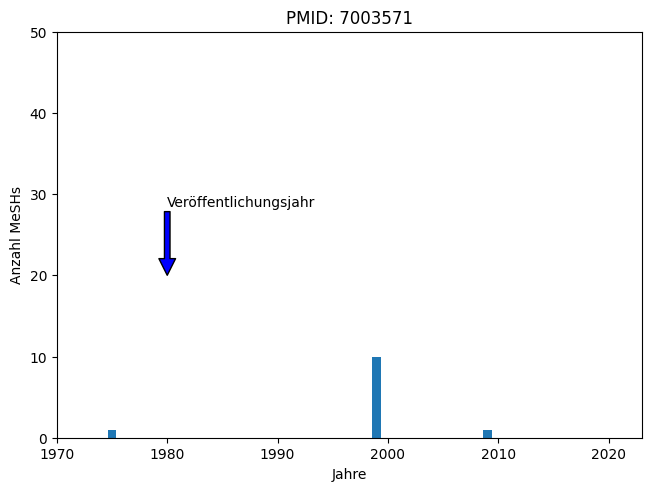

In [209]:
plotMeSHIntrosPerPmid(7003571)

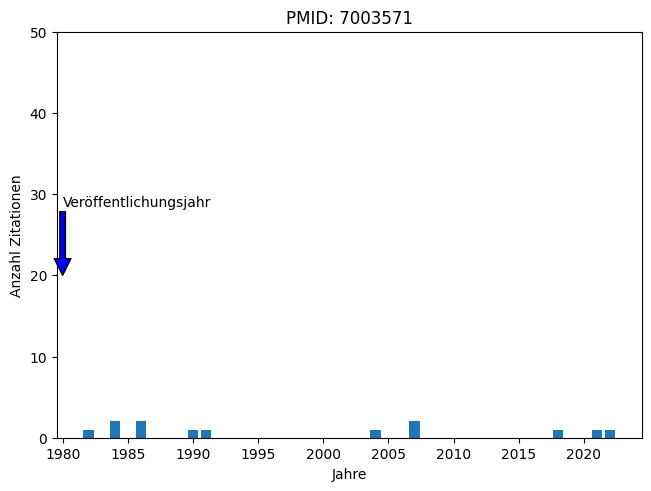

In [146]:
for id in idList:
    plotCitationsPerYear(id)